# From Pyro to NumPyro: Forecasting Hierarchical Models - Part III (Deep State-Space Model)

In this third notebook, we extend the hierarchical forecasting models from [Part II](https://juanitorduz.github.io/numpyro_hierarchical_forecasting_2/) by adding a neural network component to the state transition function. This approach is inspired by Deep State-Space Models (DSSM), which combine the interpretability of state-space models with the flexibility of neural networks.

**Key changes from Part II:**
- Add a neural network that learns **shared temporal patterns** from (previous_level, time)
- Station-specific parameters (`station_drift_bias`, `station_drift_scale`) modulate the NN output
- Use cyclical time encoding (sin/cos of hour of week) for temporal features
- All other components (seasonal, pairwise, scales) remain identical to Part II

We use [Flax NNX](https://flax.readthedocs.io/) for the neural network module, integrated with NumPyro via `nnx_module` following the pattern from the [Causal Effect Estimation notebook](https://juanitorduz.github.io/online_game_ate/).


## Prepare Notebook


In [1]:
from itertools import pairwise

import arviz as az
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import numpy as np
import numpyro
import numpyro.distributions as dist
import optax
from flax import nnx
from jax import random
from jaxtyping import Array, Float
from numpyro.contrib.control_flow import scan
from numpyro.contrib.module import nnx_module
from numpyro.examples.datasets import load_bart_od
from numpyro.infer import SVI, Predictive, Trace_ELBO
from numpyro.infer.autoguide import AutoNormal

az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

numpyro.set_host_device_count(n=14)

rng_key = random.PRNGKey(seed=42)

%load_ext autoreload
%autoreload 2
# %load_ext jaxtyping
# %jaxtyping.typechecker beartype.beartype
%config InlineBackend.figure_format = "retina"

## Read Data


In [2]:
dataset = load_bart_od()
print(dataset.keys())
print(dataset["counts"].shape)
print(" ".join(dataset["stations"]))

dict_keys(['stations', 'start_date', 'counts'])
(78888, 50, 50)
12TH 16TH 19TH 24TH ANTC ASHB BALB BAYF BERY CAST CIVC COLM COLS CONC DALY DBRK DELN DUBL EMBR FRMT FTVL GLEN HAYW LAFY LAKE MCAR MLBR MLPT MONT NBRK NCON OAKL ORIN PCTR PHIL PITT PLZA POWL RICH ROCK SANL SBRN SFIA SHAY SSAN UCTY WARM WCRK WDUB WOAK


In this example, we model all the rides from all stations to all other stations.


In [3]:
data = jnp.log1p(np.permute_dims(dataset["counts"], (1, 2, 0)))
T = data.shape[-2]
print(data.shape)

(50, 50, 78888)


## Train - Test Split

Similarly as in the previous examples, for training purposes we will use data from 90 days before the test data.


In [4]:
T2 = data.shape[-1]  # end
T1 = T2 - 24 * 7 * 2  # train/test split
T0 = T1 - 24 * 90  # beginning: train on 90 days of data

In [5]:
y = data[..., T0:T2]
y_train = data[..., T0:T1]
y_test = data[..., T1:T2]

print(f"y: {y.shape}")
print(f"y_train: {y_train.shape}")
print(f"y_test: {y_test.shape}")

y: (50, 50, 2496)
y_train: (50, 50, 2160)
y_test: (50, 50, 336)


In [6]:
n_stations = y_train.shape[0]

time = jnp.array(range(T0, T2))
time_train = jnp.array(range(T0, T1))
t_max_train = time_train.size

time_test = jnp.array(range(T1, T2))
t_max_test = time_test.size

covariates = jnp.zeros_like(y)
covariates_train = jnp.zeros_like(y_train)
covariates_test = jnp.zeros_like(y_test)

assert time_train.size + time_test.size == time.size
assert y_train.shape == (n_stations, n_stations, t_max_train)
assert y_test.shape == (n_stations, n_stations, t_max_test)
assert covariates.shape == y.shape
assert covariates_train.shape == y_train.shape
assert covariates_test.shape == y_test.shape

## Repeating Seasonal Features

We also need the JAX version of the [`periodic_repeat`](https://docs.pyro.ai/en/stable/ops.html#pyro.ops.tensor_utils.periodic_repeat) function.


In [7]:
def periodic_repeat_jax(tensor: Array, size: int, dim: int) -> Array:
    """
    Repeat a period-sized tensor up to given size using JAX.

    Parameters
    ----------
    tensor : Array
        A JAX array to be repeated.
    size : int
        Desired size of the result along dimension `dim`.
    dim : int
        The tensor dimension along which to repeat.

    Returns
    -------
    Array
        The repeated tensor.

    References
    ----------
    https://docs.pyro.ai/en/stable/ops.html#pyro.ops.tensor_utils.periodic_repeat
    """
    assert isinstance(size, int) and size >= 0
    assert isinstance(dim, int)
    if dim >= 0:
        dim -= tensor.ndim

    period = tensor.shape[dim]
    repeats = [1] * tensor.ndim
    repeats[dim] = (size + period - 1) // period
    result = jnp.tile(tensor, repeats)

    slices = [slice(None)] * tensor.ndim
    slices[dim] = slice(None, size)

    return result[tuple(slices)]

## Neural Network Definition

We define a single Flax NNX module for our Deep State-Space Model:

**TransitionMLP**: A neural network that learns shared temporal patterns from `(previous_level, sin_time, cos_time)`. The output is then modulated by station-specific probabilistic parameters defined in the model.


In [8]:
class TransitionMLP(nnx.Module):
    def __init__(
        self, din: int, dout: int, hidden_layers: list[int], *, rngs: nnx.Rngs
    ) -> None:
        self.layers = nnx.List([])

        # Create layer dimensions: [input_size, hidden1, hidden2, ..., output_size]
        layer_dims = [din, *hidden_layers, dout]

        # Build layers sequentially using pairwise iteration
        for in_dim, out_dim in pairwise(layer_dims):
            # Each layer is a linear transformation: y = Wx + b
            self.layers.append(nnx.Linear(in_dim, out_dim, rngs=rngs))

    def __call__(self, x: jax.Array) -> jax.Array:
        for layer in self.layers[:-1]:
            x = jax.nn.relu(layer(x))
        return jax.nn.tanh(self.layers[-1](x))

## Initialize Neural Network (Outside Model)

Following the pattern from [online_game_ate](https://juanitorduz.github.io/online_game_ate/), we initialize the neural network **outside** the model function and pass it as an argument. This is required for NumPyro's `nnx_module` integration to work correctly.


In [9]:
# =====================================================================
# Neural Network Configuration
# =====================================================================
# Input dimensions breakdown:
#   - previous_level: 1 (the latent state at time t-1)
#   - sin(hour_of_week): 1 (cyclical time encoding)
#   - cos(hour_of_week): 1 (cyclical time encoding)
#   Total: 3
#
# NOTE: Station-specific behavior comes from probabilistic parameters
# (station_drift_bias, station_drift_scale) that modulate the NN output.
# The NN learns SHARED temporal patterns across all stations.
# =====================================================================
transition_input_dim = 3  # previous_level + sin_time + cos_time

# Initialize random number generators for Flax
rng_key, rng_subkey = random.split(rng_key)

# Initialize the transition neural network
transition_nn = TransitionMLP(
    din=transition_input_dim,
    dout=1,  # single output: the "shared" delta contribution
    hidden_layers=[4, 8, 4],
    rngs=nnx.Rngs(rng_subkey),
)

## Model Specification

The Deep State-Space Model extends the model from Part II by adding a neural network component to the transition function.

**Key numerical stability features:**
1. **Normalize `previous_level`**: Use `tanh(previous_level / 10)` to keep NN inputs bounded
2. **Very small drift scale**: `LogNormal(-7, 0.5)` gives ~0.001 per-step deltas
3. **Tiny station bias**: `Normal(0, 0.001)` for station-specific offsets
4. **Safety clipping**: Clip accumulated levels to [-50, 50]

**Model components:**
- Neural network learns shared temporal patterns from (normalized_level, sin_time, cos_time)
- Per-station drift bias allows station-specific dynamics  
- Seasonal, pairwise, and scale parameters remain identical to Part II


In [10]:
def model(
    covariates: Float[Array, "n_series n_series t_max"],
    transition_nn: TransitionMLP,
    y: Float[Array, "n_series n_series t_max"] | None = None,
) -> None:
    """
    Deep State-Space Model with neural network transition.

    Key numerical stability features:
    1. Normalize previous_level before passing to NN (keeps inputs bounded)
    2. NN output is already tanh-bounded from the TransitionMLP class
    3. Very small drift_scale to prevent accumulation overflow
    4. Explicit clipping of pred_levels as safety measure
    """
    # Get the time and feature dimensions
    n_series, _, t_max = covariates.shape

    # Register neural network with NumPyro for optimization
    transition_nn = nnx_module("transition", transition_nn)

    # Define the plates
    origin_plate = numpyro.plate("origin", n_series, dim=-3)
    destin_plate = numpyro.plate("destin", n_series, dim=-2)
    hour_of_week_plate = numpyro.plate("hour_of_week", 24 * 7, dim=-1)

    # =====================================================================
    # DRIFT PARAMETERS - Very tight priors for numerical stability
    # With t_max=2160, even small deltas accumulate significantly
    # =====================================================================
    # Global drift scale: exp(-7) ≈ 0.0009, so max delta per step ≈ 0.001
    drift_scale = numpyro.sample("drift_scale", dist.LogNormal(loc=-7, scale=0.5))

    # Per-station bias: very small to prevent runaway accumulation
    station_drift_bias = numpyro.sample(
        "station_drift_bias",
        dist.Normal(loc=0, scale=0.001).expand([n_series]),
    )

    # Seasonal components (same as Part II)
    with origin_plate, hour_of_week_plate:
        origin_seasonal = numpyro.sample("origin_seasonal", dist.Normal(loc=0, scale=5))

    with destin_plate, hour_of_week_plate:
        destin_seasonal = numpyro.sample("destin_seasonal", dist.Normal(loc=0, scale=5))

    # Pairwise station affinity (same as Part II)
    with origin_plate, destin_plate:
        pairwise = numpyro.sample("pairwise", dist.Normal(0, 1))

    # Observation scales (same as Part II)
    with origin_plate:
        origin_scale = numpyro.sample("origin_scale", dist.LogNormal(-5, 5))
    with destin_plate:
        destin_scale = numpyro.sample("destin_scale", dist.LogNormal(-5, 5))
        scale = origin_scale + destin_scale

    # Repeat the seasonal parameters to match the length of the time series
    seasonal = origin_seasonal + destin_seasonal
    seasonal_repeat = periodic_repeat_jax(seasonal, t_max, dim=-1)

    # Neural transition function
    def transition_fn(
        carry: Float[Array, " n_series"], t: int
    ) -> tuple[Float[Array, " n_series"], Float[Array, " n_series"]]:
        """Neural network-based local level transition function.

        Numerical stability measures:
        1. Normalize previous_level to [-1, 1] range using tanh
        2. NN already outputs bounded values (tanh in TransitionMLP)
        3. Small drift_scale prevents accumulation overflow
        """
        previous_level = carry  # (n_series,)

        # =====================================================================
        # CRITICAL: Normalize previous_level to keep NN inputs bounded
        # Without this, after many steps previous_level grows unbounded
        # =====================================================================
        normalized_level = jnp.tanh(
            previous_level / 10.0
        )  # soft normalization to ~[-1, 1]

        # Cyclical time encoding (sin/cos of hour of week)
        hour_of_week = t % (24 * 7)
        angle = 2 * jnp.pi * hour_of_week / (24 * 7)
        sin_time = jnp.sin(angle)
        cos_time = jnp.cos(angle)

        # Broadcast time features to all stations: (n_series, 2)
        time_features = jnp.broadcast_to(
            jnp.stack([sin_time, cos_time]),
            (n_series, 2),
        )

        # Concatenate inputs: normalized_level + time features
        nn_input = jnp.concatenate(
            [
                normalized_level[..., None],  # (n_series, 1) - NORMALIZED
                time_features,  # (n_series, 2)
            ],
            axis=-1,
        )  # (n_series, 3)

        # Neural transition: NN output is already in [-1, 1] from tanh layers
        raw_nn_output = transition_nn(nn_input).reshape(n_series)  # (n_series,)

        # Delta = nn_output * drift_scale + station_bias
        # With drift_scale ~ 0.001 and nn_output in [-1,1], delta ~ [-0.001, 0.001]
        delta = raw_nn_output * drift_scale + station_drift_bias

        # Update level with clipping for safety
        current_level = previous_level + delta
        current_level = jnp.clip(current_level, -50.0, 50.0)  # safety clip

        return current_level, current_level

    # Compute the latent levels using scan
    _, pred_levels = scan(
        transition_fn, init=jnp.zeros((n_series,)), xs=jnp.arange(t_max)
    )

    # Transpose prediction levels: (t_max, n_series) -> (n_series, t_max)
    pred_levels = pred_levels.transpose(1, 0)

    # Add origin dimension for broadcasting: (n_series, t_max) -> (1, n_series, t_max)
    pred_levels = pred_levels[None, :, :]

    # Compute the mean of the model
    mu = pred_levels + seasonal_repeat + pairwise

    # Sample the observations
    with numpyro.handlers.condition(data={"obs": y}):
        numpyro.sample("obs", dist.Normal(loc=mu, scale=scale))

We can now visualize the model structure.


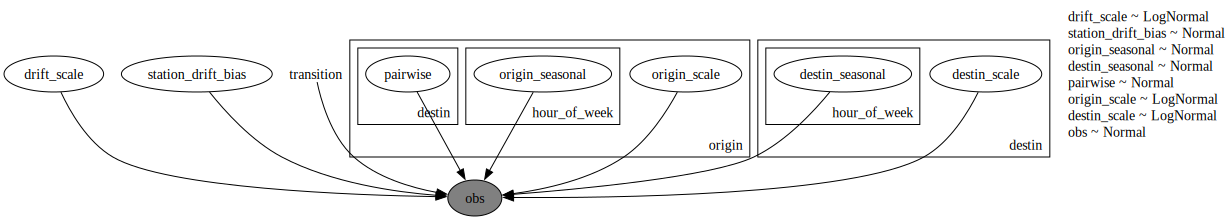

In [11]:
numpyro.render_model(
    model=model,
    model_kwargs={
        "covariates": covariates_train,
        "transition_nn": transition_nn,
        "y": y_train,
    },
    render_distributions=True,
    render_params=True,
)

## Prior Predictive Checks

As usual (highly recommended!), we should perform prior predictive checks.


In [12]:
prior_predictive = Predictive(model=model, num_samples=500, return_sites=["obs"])

rng_key, rng_subkey = random.split(rng_key)

prior_samples = prior_predictive(
    rng_subkey,
    covariates_train,
    transition_nn,
)

idata_prior = az.from_dict(
    prior_predictive={k: v[None, ...] for k, v in prior_samples.items()},
    coords={
        "time_train": time_train,
        "origin": dataset["stations"],
        "destin": dataset["stations"],
    },
    dims={"obs": ["origin", "destin", "time_train"]},
)

Let's plot the prior predictive distribution for the first $8$ stations for the destination station `ANTC`.


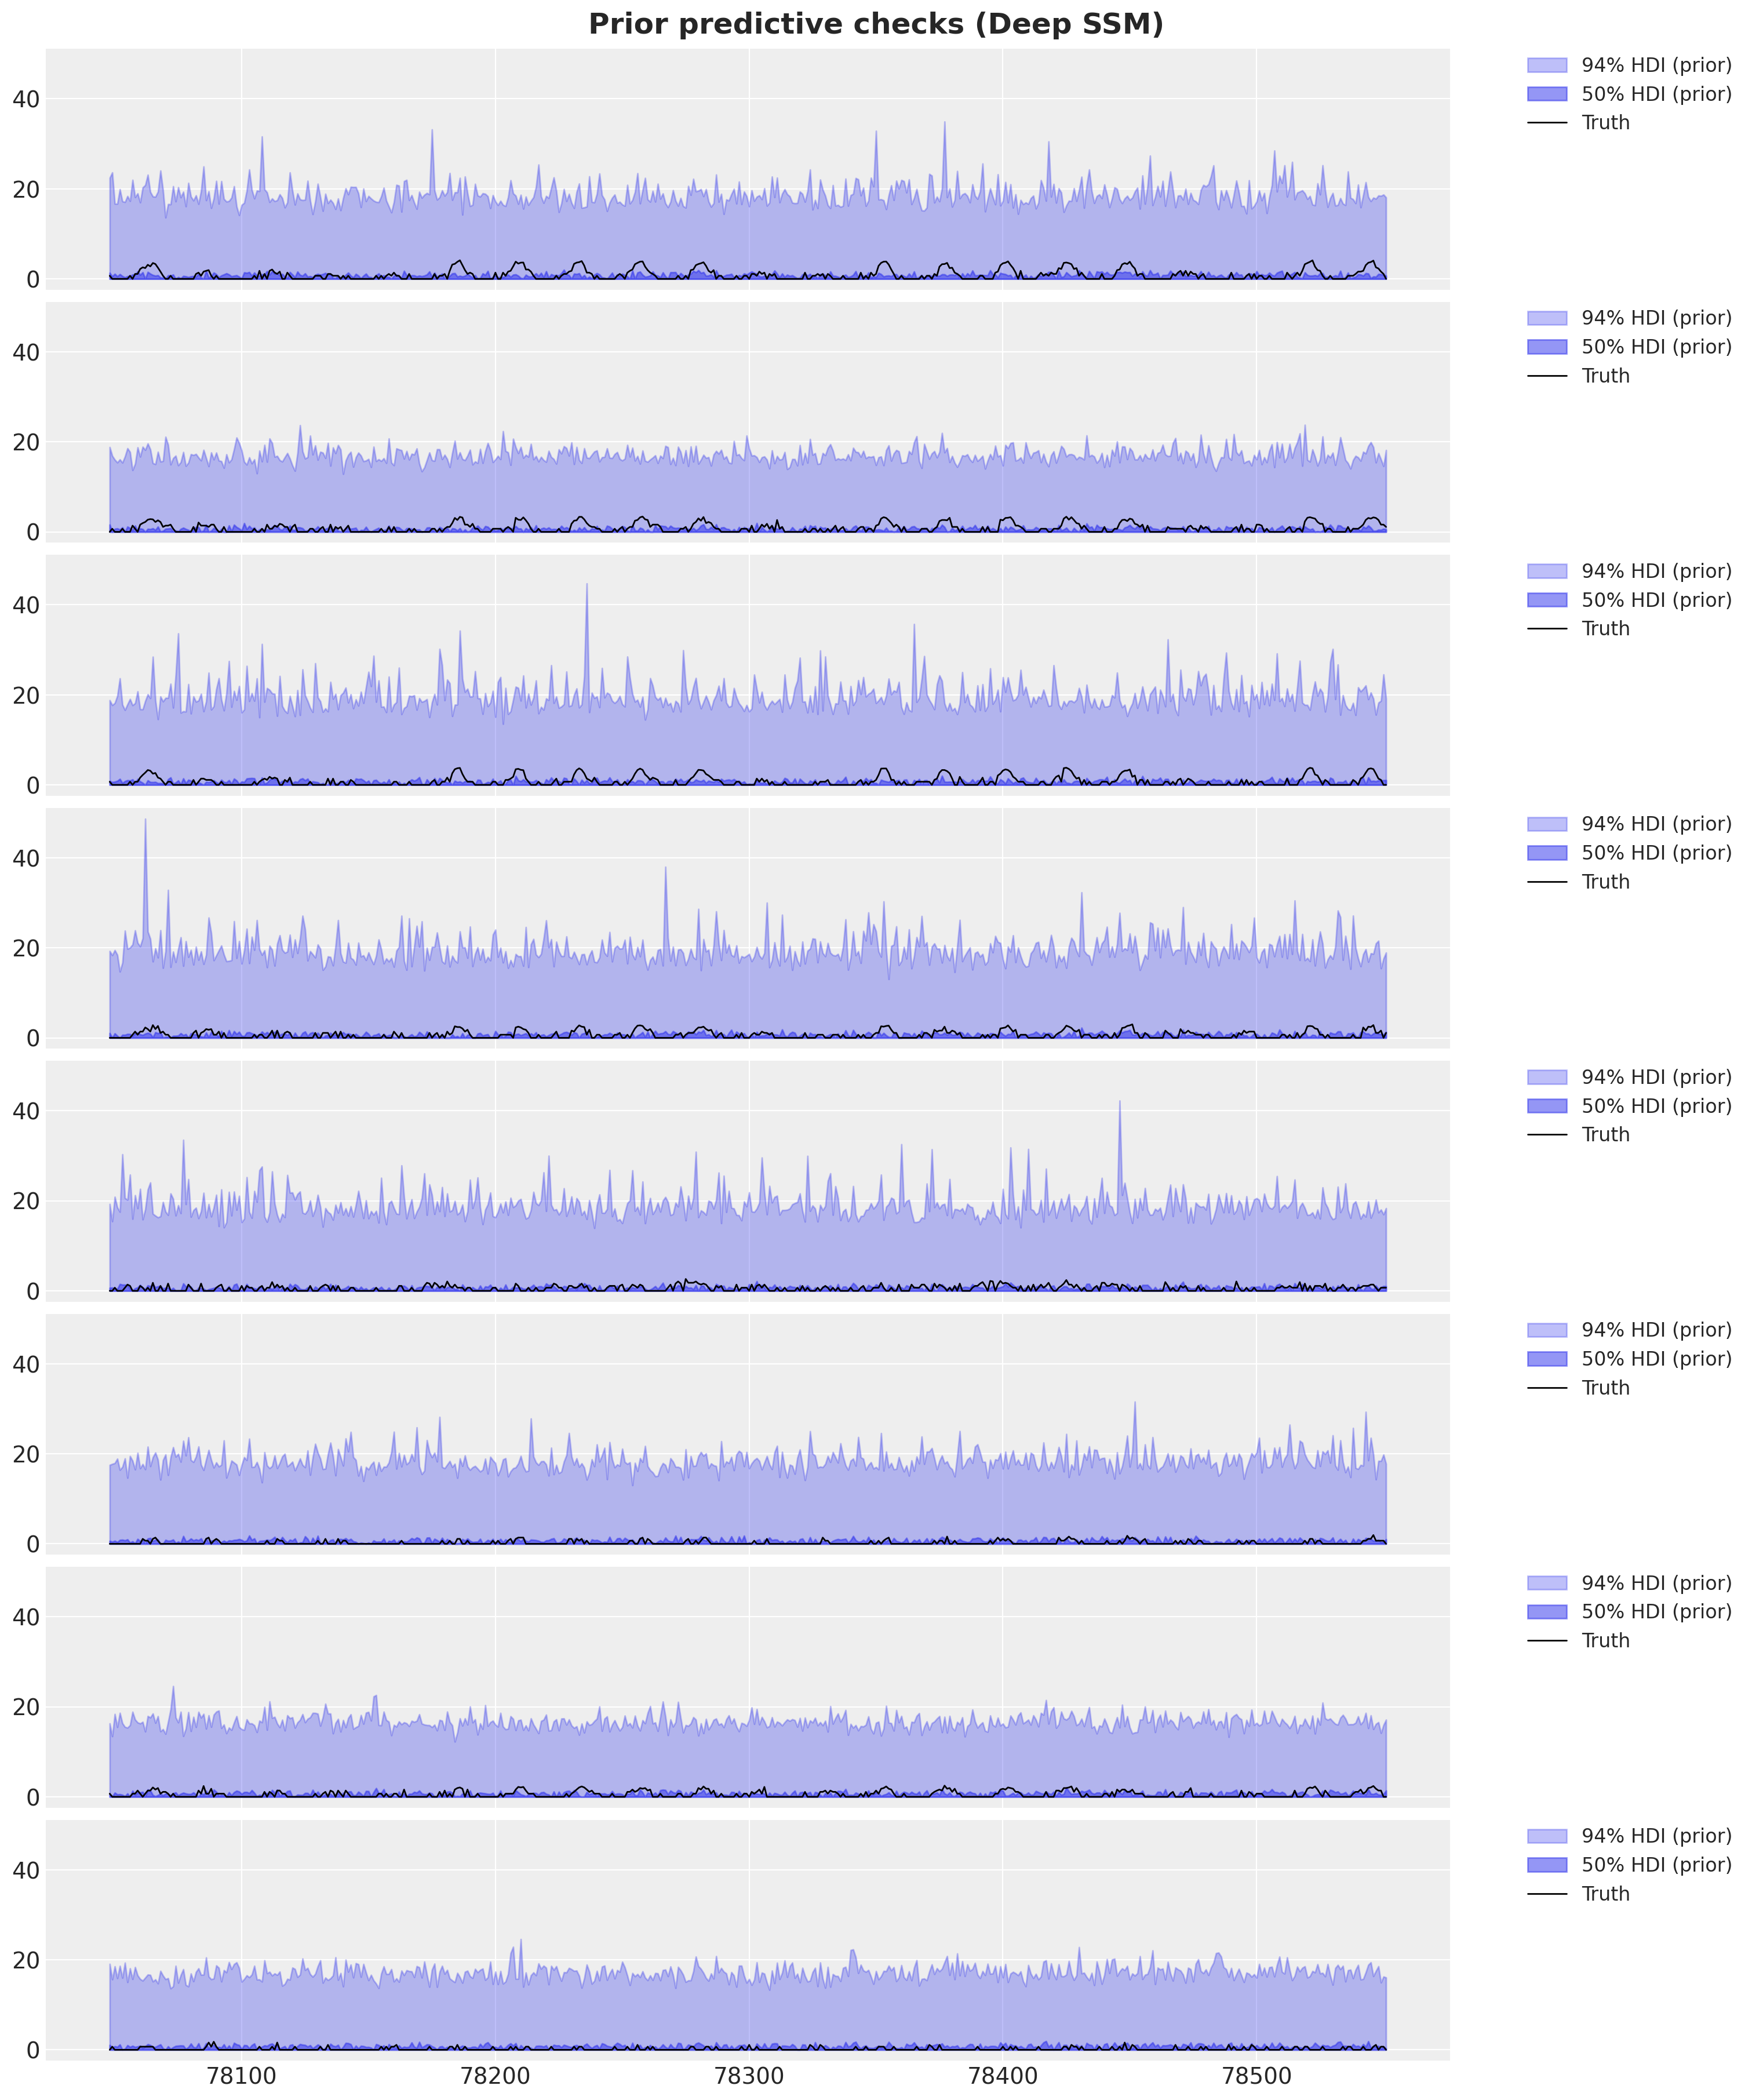

In [13]:
station = "ANTC"
idx = np.nonzero(dataset["stations"] == station)[0].item()

fig, axes = plt.subplots(
    nrows=8, ncols=1, figsize=(15, 18), sharex=True, sharey=True, layout="constrained"
)
for i, ax in enumerate(axes):
    for j, hdi_prob in enumerate([0.94, 0.5]):
        az.plot_hdi(
            time_train[time_train >= T1 - 3 * (24 * 7)],
            idata_prior["prior_predictive"]["obs"]
            .sel(destin=station)
            .isel(origin=i)[:, :, np.array(time_train) >= T1 - 3 * (24 * 7)]
            .clip(min=0),
            hdi_prob=hdi_prob,
            color="C0",
            fill_kwargs={
                "alpha": 0.3 + 0.2 * j,
                "label": f"{hdi_prob * 100:.0f}% HDI (prior)",
            },
            smooth=False,
            ax=ax,
        )

    ax.plot(
        time_train[time_train >= T1 - 3 * (24 * 7)],
        data[i, idx, T1 - 3 * (24 * 7) : T1],
        "black",
        lw=1,
        label="Truth",
    )

    ax.legend(
        bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0, fontsize=12
    )

fig.suptitle("Prior predictive checks (Deep SSM)", fontsize=18, fontweight="bold");

## Inference with SVI

We now fit the model to the data using stochastic variational inference. Note that we need to pass the neural networks as arguments to `svi.run()`.


python(27925) MallocStackLogging: can't turn off malloc stack logging because it was not enabled.
100%|██████████| 35000/35000 [15:35<00:00, 37.43it/s, init loss: 3382767616.0000, avg. loss [33251-35000]: 3669429.5000]


CPU times: user 33min 39s, sys: 6min 18s, total: 39min 57s
Wall time: 15min 42s


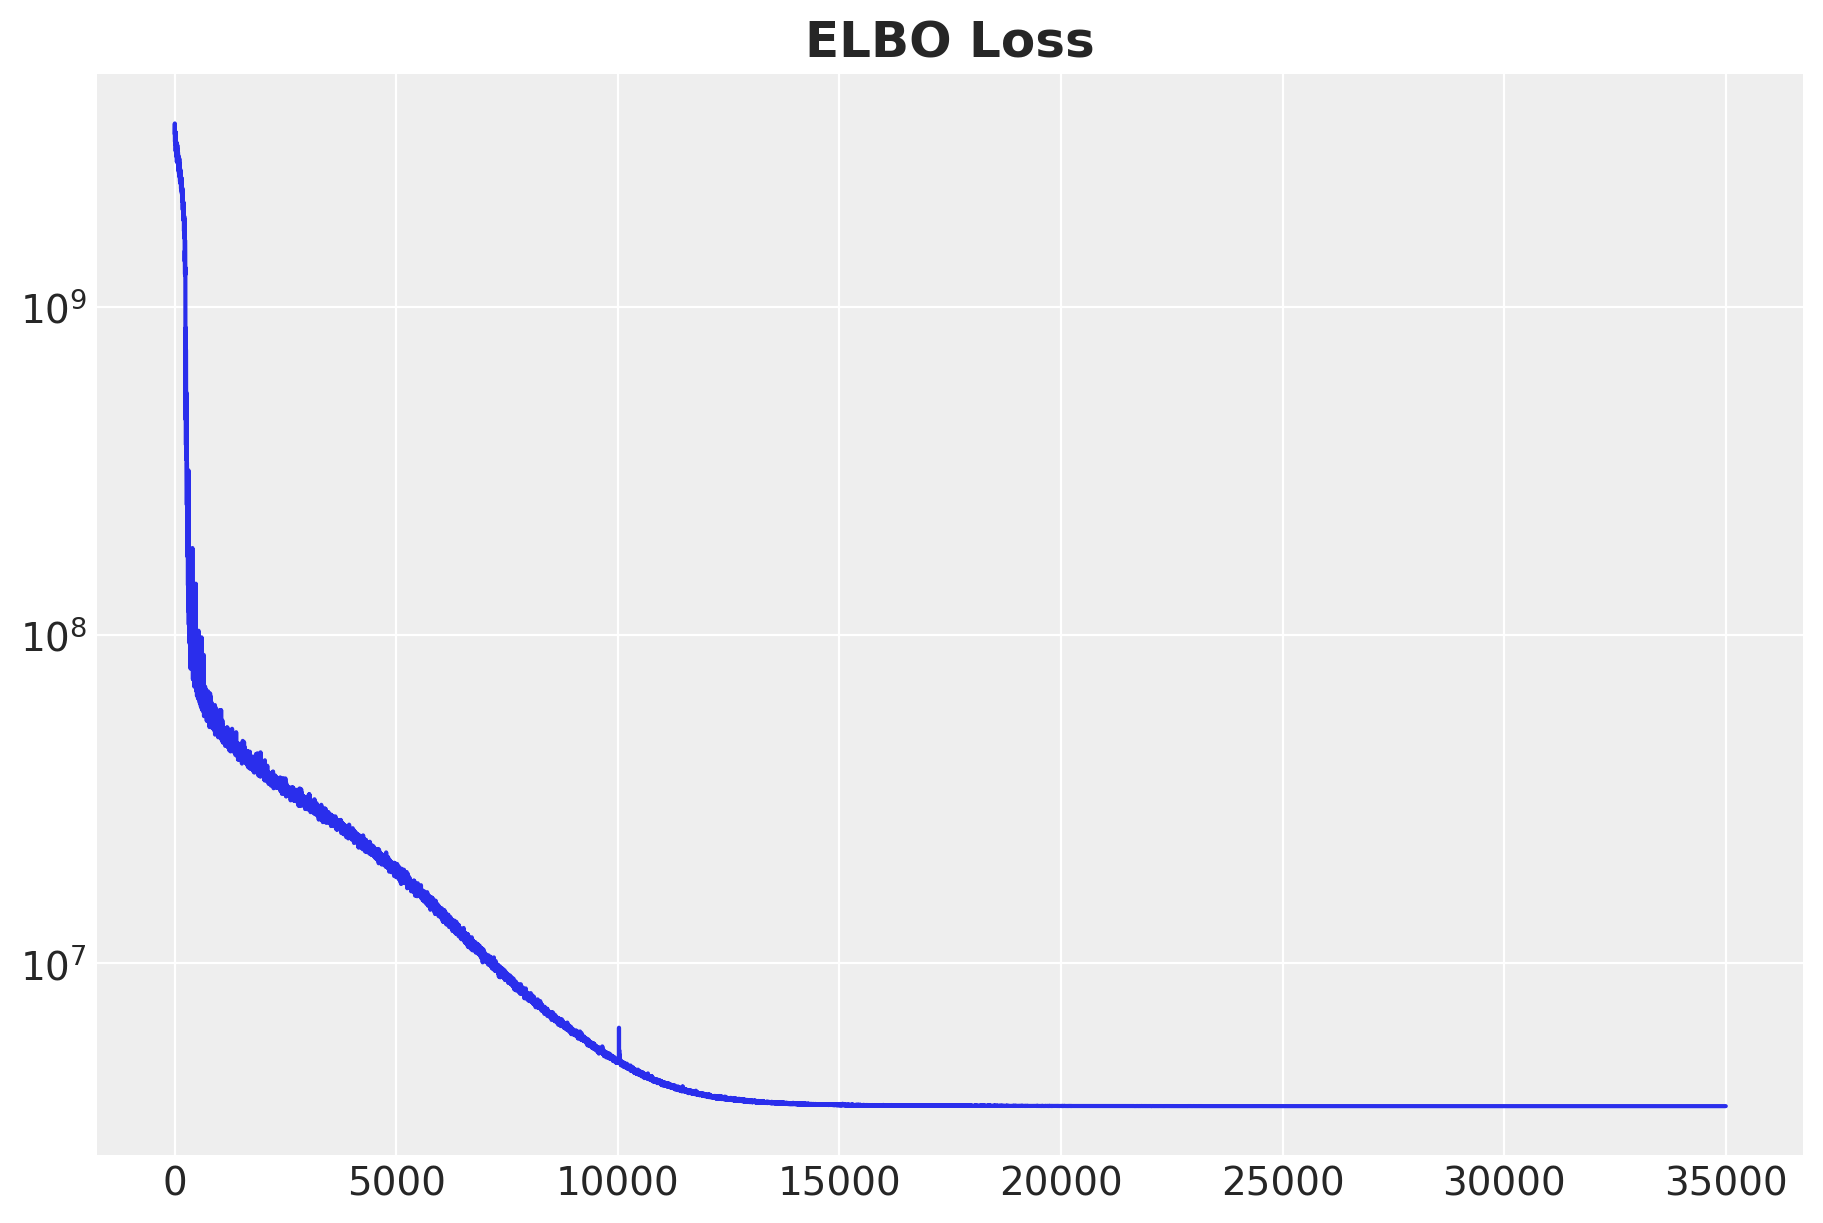

In [14]:
%%time

num_steps = 35_000

scheduler = optax.linear_onecycle_schedule(
    transition_steps=num_steps,
    peak_value=0.001,
    pct_start=0.3,
    pct_final=0.85,
    div_factor=2,
    final_div_factor=3,
)

optimizer = optax.chain(
    optax.adam(learning_rate=scheduler),
    optax.contrib.reduce_on_plateau(
        factor=0.8,
        patience=20,
        accumulation_size=100,
    ),
)

guide = AutoNormal(model)
svi = SVI(model, guide, optimizer, loss=Trace_ELBO())


rng_key, rng_subkey = random.split(key=rng_key)

svi_result = svi.run(
    rng_subkey,
    num_steps,
    covariates_train,
    transition_nn,
    y_train,
)

fig, ax = plt.subplots(figsize=(9, 6))
ax.plot(svi_result.losses)
ax.set(yscale="log")
ax.set_title("ELBO Loss", fontsize=18, fontweight="bold");

## Posterior Predictive Check

Next, we generate posterior predictive samples for the forecast for each of the station pairs.


In [15]:
posterior = Predictive(
    model=model,
    guide=guide,
    params=svi_result.params,
    num_samples=200,
    return_sites=["obs"],
)

In [16]:
rng_key, rng_subkey = random.split(rng_key)

idata_train = az.from_dict(
    posterior_predictive={
        k: v[None, ...]
        for k, v in posterior(
            rng_subkey,
            covariates_train,
            transition_nn,
        ).items()
    },
    coords={
        "time_train": time_train,
        "origin": dataset["stations"],
        "destin": dataset["stations"],
    },
    dims={"obs": ["origin", "destin", "time_train"]},
)

idata_test = az.from_dict(
    posterior_predictive={
        k: v[None, ...]
        for k, v in posterior(
            rng_subkey,
            covariates,
            transition_nn,
        ).items()
    },
    coords={
        "time": time,
        "origin": dataset["stations"],
        "destin": dataset["stations"],
    },
    dims={"obs": ["origin", "destin", "time"]},
)

To evaluate the model performance, we compute the CRPS for the training and test data. For comparison purposes, we clip the data to ensure the predictions are non-negative.


In [17]:
@jax.jit
def crps(
    truth: Float[Array, "n_series n_series t_max"],
    pred: Float[Array, "n_samples n_series n_series t_max"],
    sample_weight: Float[Array, " t_max"] | None = None,
) -> Float[Array, ""]:
    if pred.shape[1:] != (1,) * (pred.ndim - truth.ndim - 1) + truth.shape:
        raise ValueError(
            f"""Expected pred to have one extra sample dim on left.
            Actual shapes: {pred.shape} versus {truth.shape}"""
        )

    absolute_error = jnp.mean(jnp.abs(pred - truth), axis=0)

    num_samples = pred.shape[0]
    if num_samples == 1:
        return jnp.average(absolute_error, weights=sample_weight)

    pred = jnp.sort(pred, axis=0)
    diff = pred[1:] - pred[:-1]
    weight = jnp.arange(1, num_samples) * jnp.arange(num_samples - 1, 0, -1)
    weight = weight.reshape(weight.shape + (1,) * (diff.ndim - 1))

    per_obs_crps = absolute_error - jnp.sum(diff * weight, axis=0) / num_samples**2
    return jnp.average(per_obs_crps, weights=sample_weight)


crps_train = crps(
    y_train,
    jnp.array(idata_train["posterior_predictive"]["obs"].sel(chain=0).clip(min=0)),
)

crps_test = crps(
    y_test,
    jnp.array(
        idata_test["posterior_predictive"]["obs"]
        .sel(chain=0)
        .sel(time=slice(T1, T2))
        .clip(min=0)
    ),
)

print(f"Train CRPS: {crps_train:.4f}")
print(f"Test CRPS: {crps_test:.4f}")

Train CRPS: 0.2379
Test CRPS: 0.2754


Finally, we visualize the model fit and forecast.


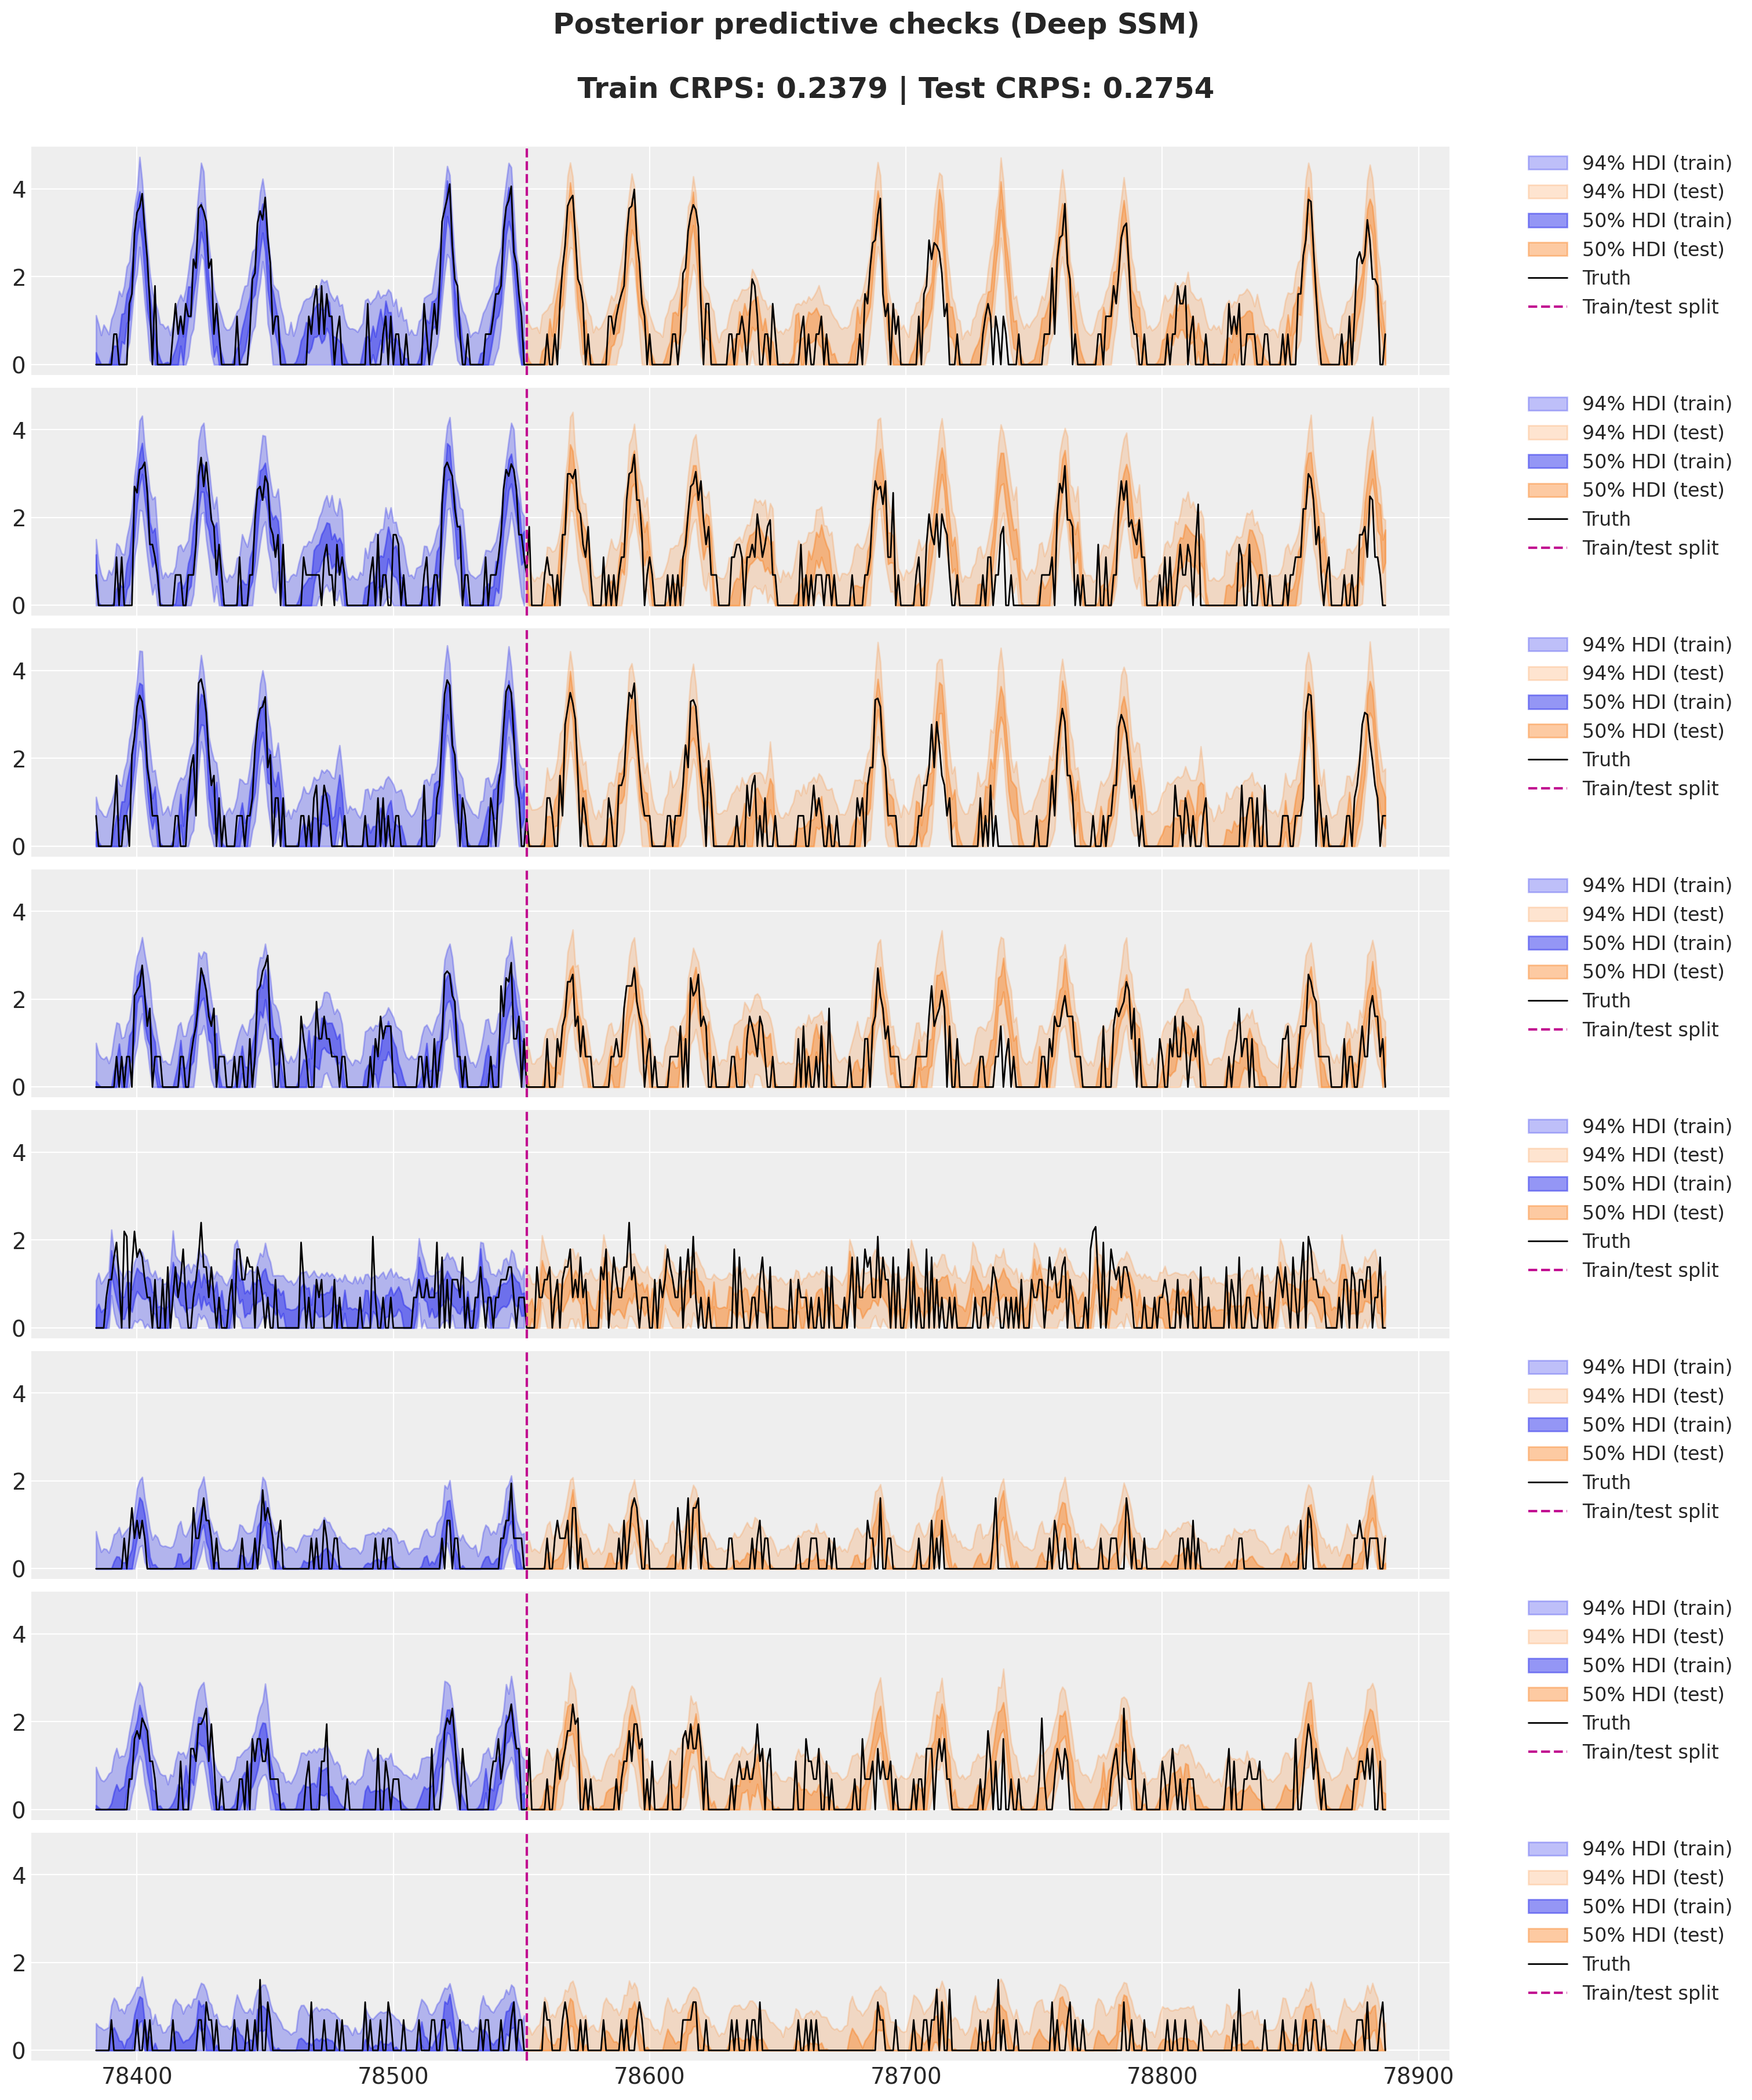

In [18]:
station = "ANTC"
idx = np.nonzero(dataset["stations"] == station)[0].item()

fig, axes = plt.subplots(
    nrows=8, ncols=1, figsize=(15, 18), sharex=True, sharey=True, layout="constrained"
)
for i, ax in enumerate(axes):
    for j, hdi_prob in enumerate([0.94, 0.5]):
        az.plot_hdi(
            time_train[time_train >= T1 - 24 * 7],
            idata_train["posterior_predictive"]["obs"]
            .sel(destin=station)
            .isel(origin=i)[:, :, np.array(time_train) >= T1 - 24 * 7]
            .clip(min=0),
            hdi_prob=hdi_prob,
            color="C0",
            fill_kwargs={
                "alpha": 0.3 + 0.2 * j,
                "label": f"{hdi_prob * 100:.0f}% HDI (train)",
            },
            smooth=False,
            ax=ax,
        )

        az.plot_hdi(
            time[time >= T1],
            idata_test["posterior_predictive"]["obs"]
            .sel(destin=station)
            .isel(origin=i)[:, :, np.array(time) >= T1]
            .clip(min=0),
            hdi_prob=hdi_prob,
            color="C1",
            fill_kwargs={
                "alpha": 0.2 + 0.2 * j,
                "label": f"{hdi_prob * 100:.0f}% HDI (test)",
            },
            smooth=False,
            ax=ax,
        )

    ax.plot(
        time[time >= T1 - 24 * 7],
        data[i, idx, T1 - 24 * 7 : T2],
        "black",
        lw=1,
        label="Truth",
    )

    ax.axvline(T1, color="C3", linestyle="--", label="Train/test split")

    ax.legend(
        bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0, fontsize=12
    )

fig.suptitle(
    f"""Posterior predictive checks (Deep SSM)

    Train CRPS: {crps_train:.4f} | Test CRPS: {crps_test:.4f}
    """,
    fontsize=18,
    fontweight="bold",
);

## Summary

In this notebook, we extended the hierarchical forecasting model from Part II by adding a neural network component to the state transition (Deep State-Space Model). Key numerical stability challenges were addressed to enable training over long time series (2160+ steps).


**Key takeaways:**

1. **Neural Network Integration**: We used a Flax NNX module with NumPyro's `nnx_module` to create a hybrid probabilistic-neural model.

2. **Pattern**: Neural networks must be initialized **outside** the model function and passed as arguments, following the pattern from [online_game_ate](https://juanitorduz.github.io/online_game_ate/).

3. **Numerical Stability is Critical** for state-space models with long time series:
   - **Normalize NN inputs**: Use `tanh(previous_level / 10)` to keep inputs bounded
   - **Very small drift priors**: `LogNormal(-7, 0.5)` gives ~0.001 per-step deltas
   - **Safety clipping**: Prevent accumulated values from growing unbounded
   
4. **Station-specific parameters** (`station_drift_bias`) allow different dynamics per station, breaking the symmetry that would otherwise make the NN produce identical outputs for all stations.

**Potential improvements:**
- Add station embeddings as NN input for richer station-specific dynamics
- Experiment with different network architectures (e.g., GRU cells)
- Use attention mechanisms for capturing long-range temporal dependencies
